In [1]:

	using Flux: onehot
	using Transformers: Vocabulary, decode
	using Random
	using Flux: throttle, @epochs, ADAMW, ADAM, RADAM, Momentum, Optimiser, logitcrossentropy, params
	using Flux: softmax, onecold
	using DataStructures: Queue, enqueue!, dequeue!
	Random.seed!(42)


MersenneTwister(UInt32[0x0000002a], Random.DSFMT.DSFMT_state(Int32[964434469, 1073036706, 1860149520, 1073503458, 1687169063, 1073083486, -399267803, 1072983952, -909620556, 1072836235  …  -293054293, 1073002412, -1300127419, 1073642642, 1917177374, -666058738, -337596527, 1830741494, 382, 0]), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], UInt128[0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000  …  0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x0000000000

In [2]:

module Datasets include("onJulia/src/datasets.jl") end
dataSetlength, vocab, sample = Datasets.openDataset("input.txt")
batch(dataLength,batchLength ) = hcat((sample(dataLength) for x in 1:batchLength)...)

## ---
module Model include("onJulia/src/model.jl") end

lengthOfSentences=520
model=Model.minGPT(maxBlockSize=lengthOfSentences, vocabSize=length(vocab))


## ---


# for a batch of sentences, extract 1st to one before last character as input
# and 2nd to last char of each sentence as prediction.  Shape the predictred
# values as a long one dim series of values, one hot encode them using the vocab

trainingDataPair(b)=(b[1:end-1, :], onehot(vocab, reshape(b[2:end,:], :)))
trainingData(dataLength,batchLength)= [trainingDataPair(batch(dataLength,batchLength))
		for i in 1:dataSetlength/(dataLength*batchLength)]

function loss(x,y)
	yhat=model(x)
	logitcrossentropy(reshape(yhat,size(yhat)[1], :), y)
end


function validate()
	s=collect("Wher")
	for i in 1:20
		out=model(vocab(s))
		push!(s, decode(vocab,onecold(softmax(out)[:,end])))
	end
	join(s)
end



datasize = length(s) = 1115394


validate (generic function with 1 method)

In [3]:
opt = RADAM()

## ---
module Train include("onJulia/src/train.jl") end

Main.Train

In [4]:


function sampleFromModel(s="Whe", minprob=.05) 
	function explore(x, minprob)
		x[1] < minprob && return currentRes
		out=model(vocab(collect(x[2])))
		choices=sort(collect(zip(softmax(out[:,end]), decode(vocab, collect(1:size(out)[1])))), rev=true)
		options = [(x[1]*np, x[2]*nc) for (np,nc) in choices if (x[1]*np) > minprob ]
	end
	toexplore=Queue{Tuple{Float32,String}}()
	enqueue!(toexplore,(1, s))  #start with the initial string and prob 1
	results=[]
	for i in toexplore
		nxt=dequeue!(toexplore)
		res=explore(nxt, minprob)
		if isempty(res)  # go as long as you can't add any more character and satisfy the prob
			push!(results, nxt)
			continue #continue emptying the queue
		end
		for r in res
			enqueue!(toexplore, r)  ## add elements for further exploration
		end
	end
    #elements of the results are (prob, string), sort from high to low of the 
	#longest match with highest prob
	sort(results, by=x->(length(x[2]), x[1]), rev=true)
end


sampleFromModel (generic function with 3 methods)

In [6]:


numberOfSentencesInBatch=12

Train.train!(loss,
            params(model),
            trainingData(lengthOfSentences, numberOfSentencesInBatch),
            opt,
            sampleFromModel )



ctr = 0
(ctr, training_loss) = (0, 2.466491f0)
training_accuracy = validate() = Any[(0.25684255f0, "Whe "), (0.104611516f0, "When"), (0.09987584f0, "Whes"), (0.080615066f0, "Wher"), (0.07318395f0, "Whea")]
ctr = 1
ctr = 2
ctr = 3
ctr = 4
ctr = 5
ctr = 6
ctr = 7
ctr = 8
ctr = 9
ctr = 10
(ctr, training_loss) = (10, 2.4720771f0)
training_accuracy = validate() = Any[(0.13087411f0, "Wher"), (0.08252002f0, "Whes"), (0.07195043f0, "When")]
ctr = 11
ctr = 12
ctr = 13
ctr = 14
ctr = 15
ctr = 16
ctr = 17
ctr = 18
ctr = 19
ctr = 20
(ctr, training_loss) = (20, 2.497666f0)
training_accuracy = validate() = Any[(0.30942392f0, "Whe "), (0.09754854f0, "Wher"), (0.083803676f0, "Whea"), (0.08275804f0, "When")]
ctr = 21
ctr = 22
ctr = 23
ctr = 24
ctr = 25
ctr = 26
ctr = 27
ctr = 28
ctr = 29
ctr = 30
(ctr, training_loss) = (30, 2.445755f0)
training_accuracy = validate() = Any[(0.3057037f0, "Whe "), (0.11930243f0, "Wher"), (0.099242374f0, "Whes"), (0.077167094f0, "When")]
ctr = 31
ctr = 32
ctr = 33
ctr = 34

In [8]:
res = sampleFromModel("Where i", 0.01)


30-element Array{Any,1}:
 (0.022746878f0, "Where ithe")
 (0.015052609f0, "Where ith ")
 (0.014576222f0, "Where ind ")
 (0.011685127f0, "Where is t")
 (0.011177978f0, "Where ing ")
 (0.048388213f0, "Where in ")
 (0.034417223f0, "Where it ")
 (0.017314265f0, "Where ive")
 (0.016214019f0, "Where ine")
 (0.016022786f0, "Where int")
 (0.015842611f0, "Where ise")
 (0.015654119f0, "Where ist")
 (0.013857532f0, "Where ich")
 ⋮
 (0.011109406f0, "Where ice")
 (0.0108422255f0, "Where ite")
 (0.010822845f0, "Where ito")
 (0.010366791f0, "Where ins")
 (0.010330881f0, "Where ir ")
 (0.010087078f0, "Where ire")
 (0.03179735f0, "Where ig")
 (0.025276257f0, "Where if")
 (0.023336668f0, "Where ie")
 (0.012093356f0, "Where io")
 (0.011255524f0, "Where ip")
 (0.010583314f0, "Where ia")

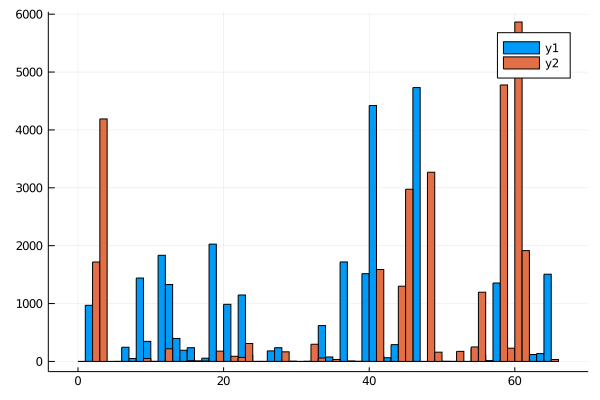

In [31]:
using StatsBase
using Plots
function getOutputResults(m, data, limit=5)
	output=[]
	ctr=0
	for (x,y) in data
		out=softmax(m(x))
		out=reshape(out,size(out)[1], :)
		push!(output, onecold(out)...)  ## get the encoded vocab using straight onecold, not onecold(vocab, ..) version

		ctr +=1
		if  ctr > limit break end
	end
	convert(Array{Int}, output)
end

d=trainingData(lengthOfSentences, numberOfSentencesInBatch)
function OutputHistogram(m)
	outChars=getOutputResults(m, d)
	fit(Histogram, outChars, 0:1:length(vocab))
end

#Try a untrained model
raw=OutputHistogram(Model.minGPT(maxBlockSize=lengthOfSentences, vocabSize=length(vocab)))

#... and trained model
trained=OutputHistogram(model)

plot(raw)
plot!(trained)